*I was interested in the question of studying the reactions of binary indicators pff, and in this regard, I decided to consider the possibility of influencing them with a new metric* - **"body mass index"** *(the ratio of a player's weight to his height). Will positive indicator reactions appear more often at a certain value of this metric? Let's see!*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=True)
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



This project will consider the possibility of the influence of players' body mass indexes on the behavior of binary PFF indicators (ProFootballFocus collects and analyzes in detail the data of NFL teams and players, providing scores and advanced statistics, including for recruiting agencies.)
   - we will consider the reaction of binary indicators only to changes in body mass index;
   - the study will be carried out separately for defense and attack, as they include specific indices.


First, we need to connect two sets with the data we need to work with, only columns with the information of interest will be taken from them and combined into the need_data table. Further, we will convent height into centimeters, weight into kilograms.

In [3]:
data = data_players.merge(data_scouting, on='nflId')
need_data = data[['nflId', 'height', 'weight', 'officialPosition', 'pff_role', 'pff_hit', 'pff_hurry',
                  'pff_sack', 'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']]
need_data.height = need_data.height.str.replace('-', '.').astype('float')
foot_height = need_data.height.unique()
need_data.height = need_data.height.replace(foot_height, foot_height*30.48).astype('int').round(0)
lb_weight = need_data.weight.unique()
need_data.weight = need_data.weight.replace(lb_weight, lb_weight*0.45).astype('int').round(0)

Let's create a metric "body mass index" as the ratio of the player's weight to his height.

In [4]:
need_data['mass_index'] = need_data['weight']/need_data['height']
need_data.mass_index = need_data.mass_index.round(2)

In [5]:
display(need_data.mass_index.unique())

array([0.52, 0.55, 0.75, 0.54, 0.6 , 0.73, 0.5 , 0.72, 0.65, 0.51, 0.76,
       0.71, 0.58, 0.56, 0.69, 0.63, 0.62, 0.61, 0.74, 0.59, 0.64, 0.78,
       0.48, 0.49, 0.66, 0.67, 0.53, 0.57, 0.45, 0.68, 0.81, 0.47, 0.7 ,
       0.44, 0.8 , 0.77, 0.82, 0.79, 0.84, 0.46, 0.43, 0.83, 0.4 , 0.42,
       0.9 , 0.85])

Then it is necessary to determine whether the distribution of our new metric is the same for groups with negative and positive reactions of the pff indicator. To do this, we will conduct **a Mann-Whitney U Test**. Graphs visualizing the distribution will also be built.

**H0: the distributions of mass_index for pff_indicator == 0 and pff_indicator == 1  are equal. \
H1: the distributions of mass_index for pff_indicator == 0 and pff_indicator == 1 are unequal.**

In [6]:
def u_test(con_1, con_2):
    sample_1 = need_data.query(con_1).mass_index
    sample_2 = need_data.query(con_2).mass_index
    stat, p_value = mannwhitneyu(sample_1, sample_2)
    print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
    alpha = 0.05
    if p_value > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    ax = pd.Series(need_data.query(con_1).mass_index).plot.kde();
    pd.Series(need_data.query(con_2).mass_index).plot.kde(ax=ax);

Mann-Whitney U Test: statistic=43785250.50, p-value=0.0738
Same distribution (fail to reject H0)


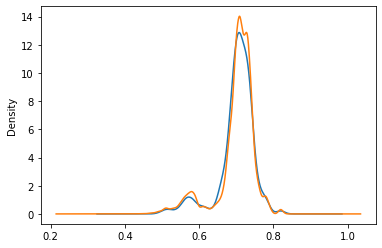

In [7]:
u_test('pff_beatenByDefender==1', 'pff_beatenByDefender==0')

Mann-Whitney U Test: statistic=12802451.00, p-value=0.6864
Same distribution (fail to reject H0)


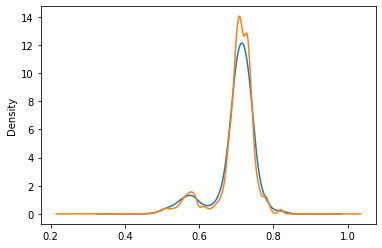

In [8]:
u_test('pff_hitAllowed==1', 'pff_hitAllowed==0')

Mann-Whitney U Test: statistic=47436125.00, p-value=0.4388
Same distribution (fail to reject H0)


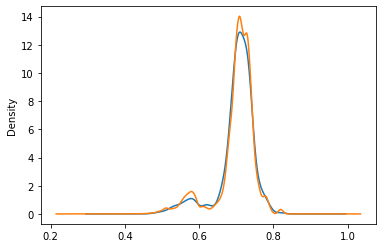

In [9]:
u_test('pff_hurryAllowed==1', 'pff_hurryAllowed==0')

Mann-Whitney U Test: statistic=7783535.50, p-value=0.0001
Different distribution (reject H0)


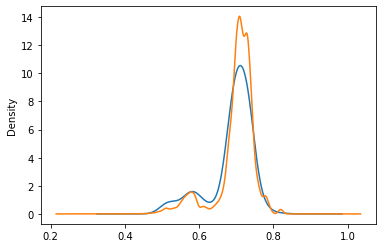

In [10]:
u_test('pff_sackAllowed==1', 'pff_sackAllowed==0')

Mann-Whitney U Test: statistic=55276228.00, p-value=0.0000
Different distribution (reject H0)


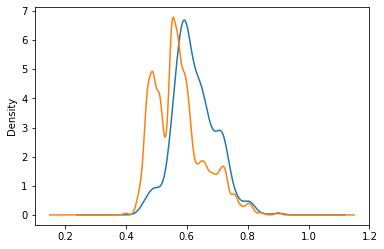

In [11]:
u_test('pff_hit==1', 'pff_hit==0')

Mann-Whitney U Test: statistic=191742603.50, p-value=0.0000
Different distribution (reject H0)


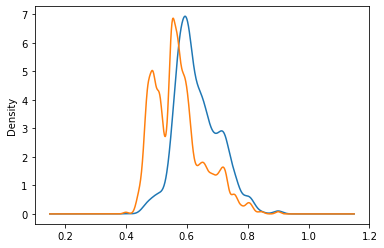

In [12]:
u_test('pff_hurry==1', 'pff_hurry==0')

Mann-Whitney U Test: statistic=38729481.50, p-value=0.0000
Different distribution (reject H0)


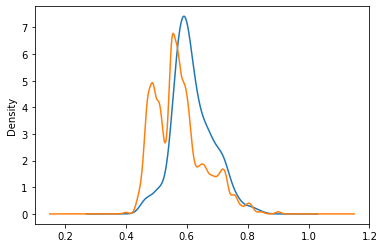

In [13]:
u_test('pff_sack==1', 'pff_sack==0')

**Conclusions:** as we can see, all three binary indicators of the actions of defending players (hit, hurry, sack) and one attack indicator (sackAllowed) **have a different distribution of body mass index for groups 0 and 1**, which is confirmed by tests and visualization.
> Further, we will consider the reactions of these indicators to changes in the players' body mass index.

Let's distribute body mass indices into 6 categories of the same dimension.

In [14]:
def group_index(index):
    if 0.4 < index < 0.5:
        return '0.4-0.49'
    if index < 0.6:
        return '0.5-0.59'
    if index < 0.7:
        return '0.6-0.69'
    if index < 0.8:
        return '0.7-0.79'
    if index < 0.9:
        return '0.8-0.89'
    return '0.9-0.95'

In [15]:
need_data['index_group'] = need_data['mass_index'].apply(group_index)

Next, the data from the category "official position of the player" was studied and distributed accordingly in defense and attack.

In [16]:
def group_position(position):
    if position in ['QB', 'T', 'TE', 'WR', 'C', 'G', 'RB', 'FB']:
        return 'offensive'
    return 'defensive'

In [17]:
need_data['position_group'] = need_data['officialPosition'].apply(group_position)

Next, interactive charts and data groups by a specific indicator and type of game position will be presented.

First, the reactions of indicators to changes in the mass index of offensive players will be considered:

In [18]:
offensive_data_pivot = need_data[need_data.position_group=="offensive"].pivot_table(index='index_group',
         values=['pff_sackAllowed'], aggfunc='sum')

In [19]:
display(offensive_data_pivot)

,pff_sackAllowed
index_group,
0.4-0.49,1.0
0.5-0.59,44.0
0.6-0.69,97.0
0.7-0.79,227.0
0.8-0.89,1.0


In [20]:
def build_bar(col, color):    
    offensive_data_pivot[col].iplot(kind='bar', opacity=1, color=color)

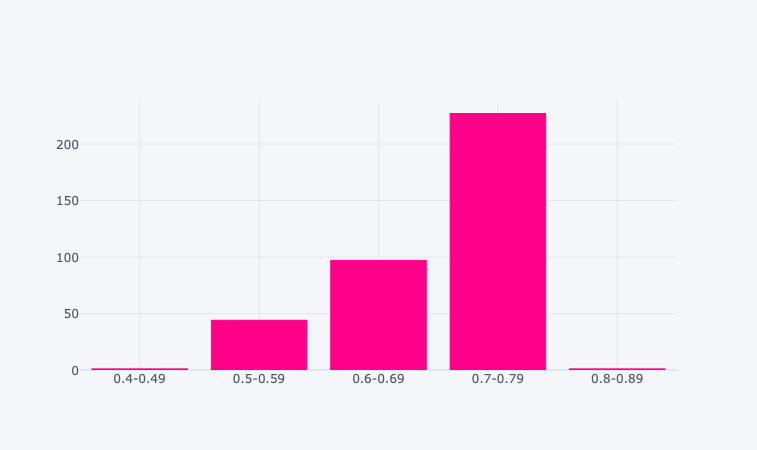

In [21]:
build_bar('pff_sackAllowed', 'pink')

As can be clearly seen from the visualization, indicator aimed at evaluating the actions of attacking players respond best to indices belonging to the interval 0.7-0.79.

Consider the influence of body mass indices on the behavior of indicators in the case of defense players.

In [22]:
defensive_data_pivot = need_data[need_data.position_group=="defensive"].pivot_table(index='index_group',
         values=['pff_hit', 'pff_hurry', 'pff_sack'], aggfunc='sum')

In [23]:
display(defensive_data_pivot)

,pff_hit,pff_hurry,pff_sack
index_group,,,
0.4-0.49,30.0,58.0,17.0
0.5-0.59,275.0,895.0,219.0
0.6-0.69,379.0,1312.0,276.0
0.7-0.79,137.0,532.0,82.0
0.8-0.89,18.0,66.0,8.0
0.9-0.95,2.0,11.0,0.0


In [24]:
def build_bar_two(col, color):    
    defensive_data_pivot[col].iplot(kind='bar', opacity=1, color=color)

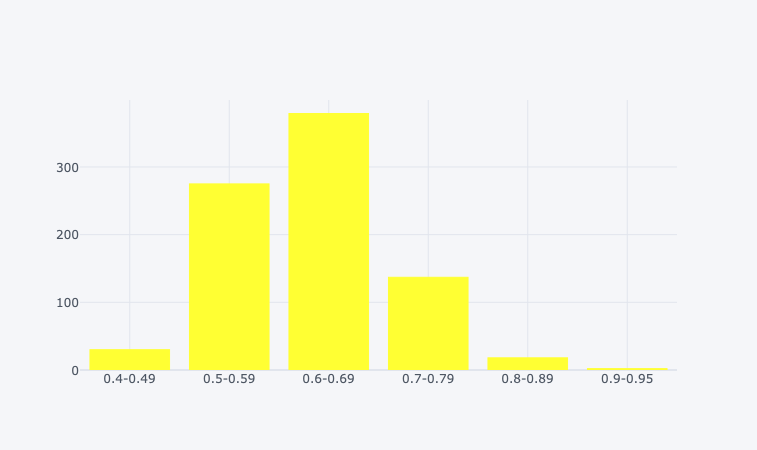

In [25]:
build_bar_two('pff_hit', 'yellow')

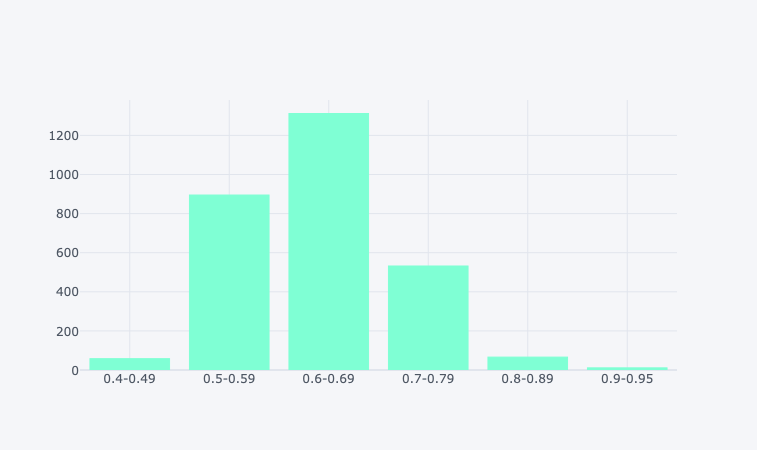

In [26]:
build_bar_two('pff_hurry', 'aquamarine')

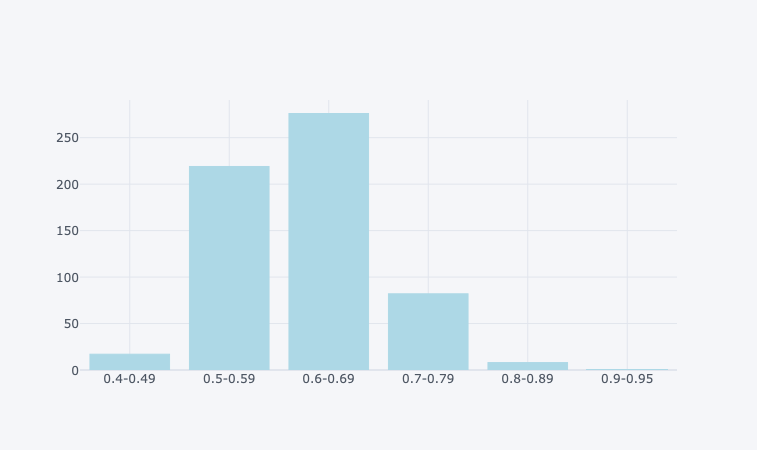

In [27]:
build_bar_two('pff_sack', 'lightblue')

In this case, the "best" is the index, which is in the range of 0.6-0.69 and in the range of 0.5-0.59.

Now it will be interesting to see - which **specific body mass indices** will give more positive reactions to the indicators we are considering.

In [28]:
def bar_mass_index(pos, col, color):    
    need_data.query(pos).groupby('mass_index')[col].sum().iplot(kind='bar', opacity=1, color=color)

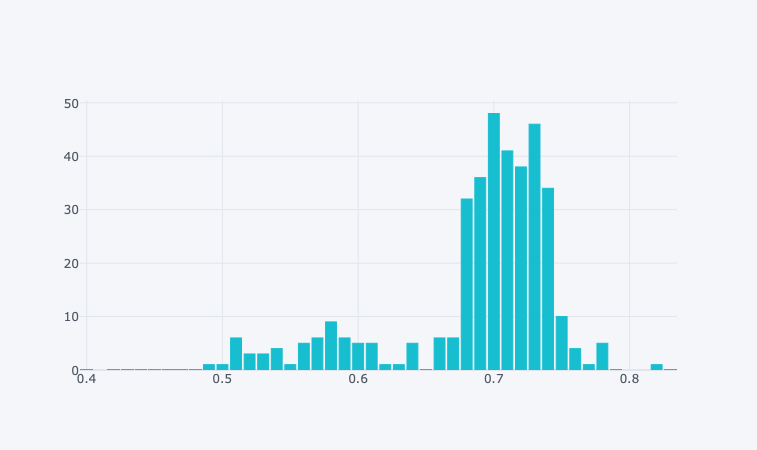

In [29]:
bar_mass_index('position_group=="offensive"', 'pff_sackAllowed', 'java')

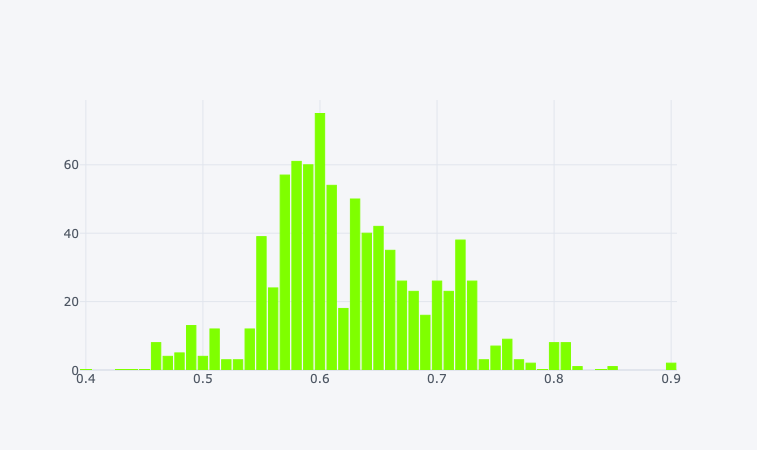

In [30]:
bar_mass_index('position_group=="defensive"', 'pff_hit', 'chartreuse')

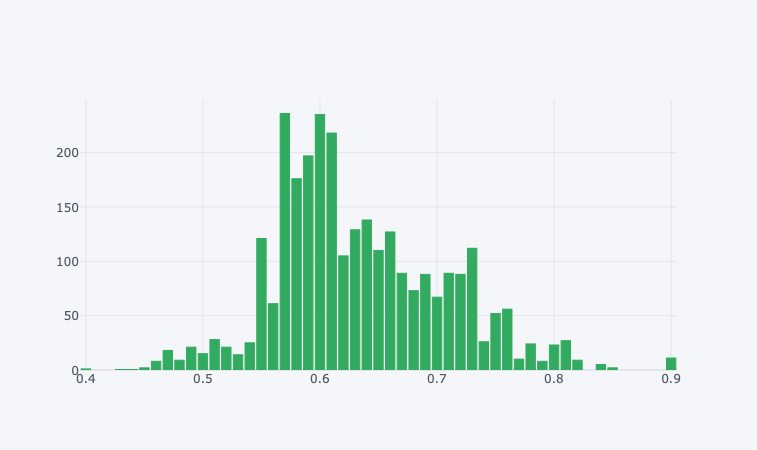

In [31]:
bar_mass_index('position_group=="defensive"', 'pff_hurry', 'grassgreen')

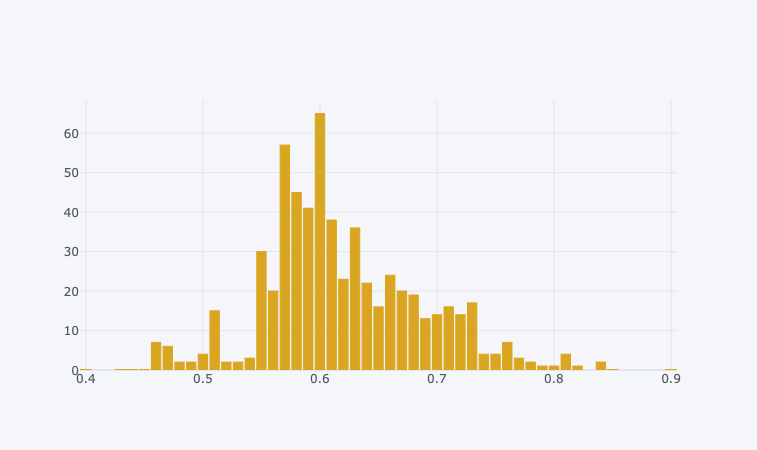

In [32]:
bar_mass_index('position_group=="defensive"', 'pff_sack', 'goldenrod')

Based on these results, the following conclusions can be drawn:
- for attacking players, the following mass indices achieved the largest reaction (hereinafter the name of the indicator, the index value, the number of reactions):
  - sackallowed - 0.7(48), 0.73(46), 0.71(41);
- for defensive players:
  - hit - 0.6(75)
  - hurry - 0.57(236), 0.6(235), 0.61(218)
  - sack - 0.6(65), 0.57(57).

<font color='green'>General conclusion</font>
So, we considered the probability of the influence of the body mass index of the defending and attacking players on the reactions of binary indicators pff.
In the course of the study, data were obtained indicating that the body mass index of the players really affects the reaction of the indices, that is, the presence of a certain ratio of the player’s weight and height can bring a positive result.
In the future, it is possible to predict the reactions of indicators in the presence of the indicated metric data of the players.